# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 721.9 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 48.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 56.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0
    Uninstalling torch-1.13.0:
      Successfully uninstalled torch-1.13.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0
    Uninstalling torchvision-0.14.0:
      Successfully uninstalled torchvision-0.14.0


In [ ]:
 !pip install wheel==0.34.1

  Attempting uninstall: wheel
    Found existing installation: wheel 0.38.4
    Uninstalling wheel-0.38.4:
      Successfully uninstalled wheel-0.38.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.1 requires wheel>=0.37.0, but you have wheel 0.34.1 which is incompatible.


In [ ]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torchvision -i http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl 
import torch

Looking in indexes: http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl


In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0
# import PIL
# print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

import PIL
print(PIL)

<module 'PIL' from '/opt/conda/lib/python3.7/site-packages/PIL/__init__.py'>


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# работаю с ноутбуком на kaggle

In [ ]:
# !ls /content/gdrive/
!ls /kaggle/input/journey-springfield

characters_illustration.png  sample_submission.csv  testset  train


In [ ]:
# !unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls /kaggle/input/journey-springfield -1

characters_illustration.png
sample_submission.csv
testset
train


In [ ]:
!ls /kaggle/input/journey-springfield/train

simpsons_dataset


In [ ]:
!ls /kaggle/input/journey-springfield/testset

testset


In [ ]:
from pathlib import Path
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

In [ ]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) # 20933
print(len(test_files)) # 991

20933
991


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Apr  3 14:07:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# TRAIN_DIR = Path('train/dataset')
# TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, random_state=42)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

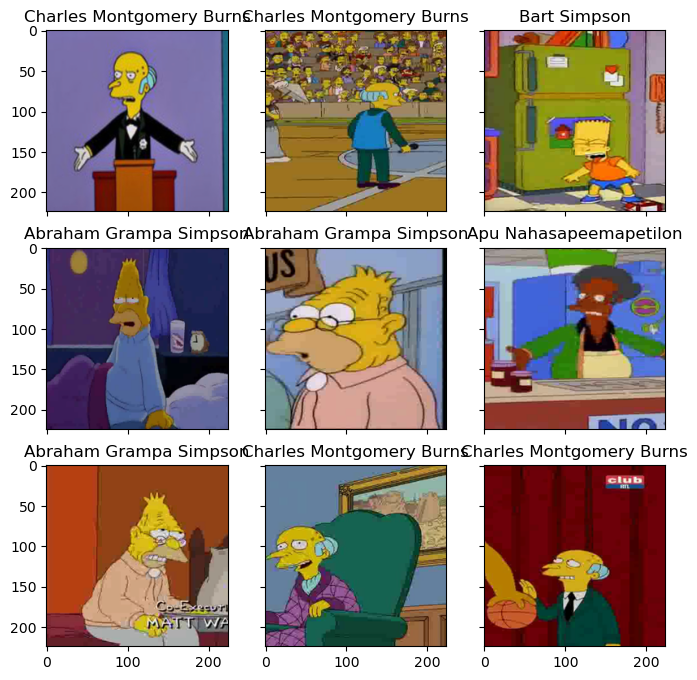

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2)
        # )
        # self.conv2 = nn.Sequential(
        #     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2)
        # )
        # self.conv3 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2)
        # )
        # self.conv4 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2)
        # )
        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2)
        # )
        
        # self.out = nn.Linear(96 * 5 * 5, n_classes)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
  
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu4 = nn.LeakyReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu5 = nn.LeakyReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=2)

        self.ln1 = nn.Linear(96 * 5 * 5, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.relu6 = nn.LeakyReLU()
        self.ln2 = nn.Linear(1024, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.relu7 = nn.LeakyReLU()
        self.out = nn.Linear(256, n_classes)
  
    def forward(self, x):
        # x = self.conv1(x)
        # x = self.conv2(x)
        # x = self.conv3(x)
        # x = self.conv4(x)
        # x = self.conv5(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.pool5(x) 

        x = x.view(x.size(0), -1)

        x=self.ln1(x)
        x=self.bn6(x)
        x=self.relu6(x)
        x=self.ln2(x)
        x=self.bn7(x)
        x=self.relu7(x)

        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, sheduler=None):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    model.train(True)
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    if sheduler is not None:
        sheduler.step()
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

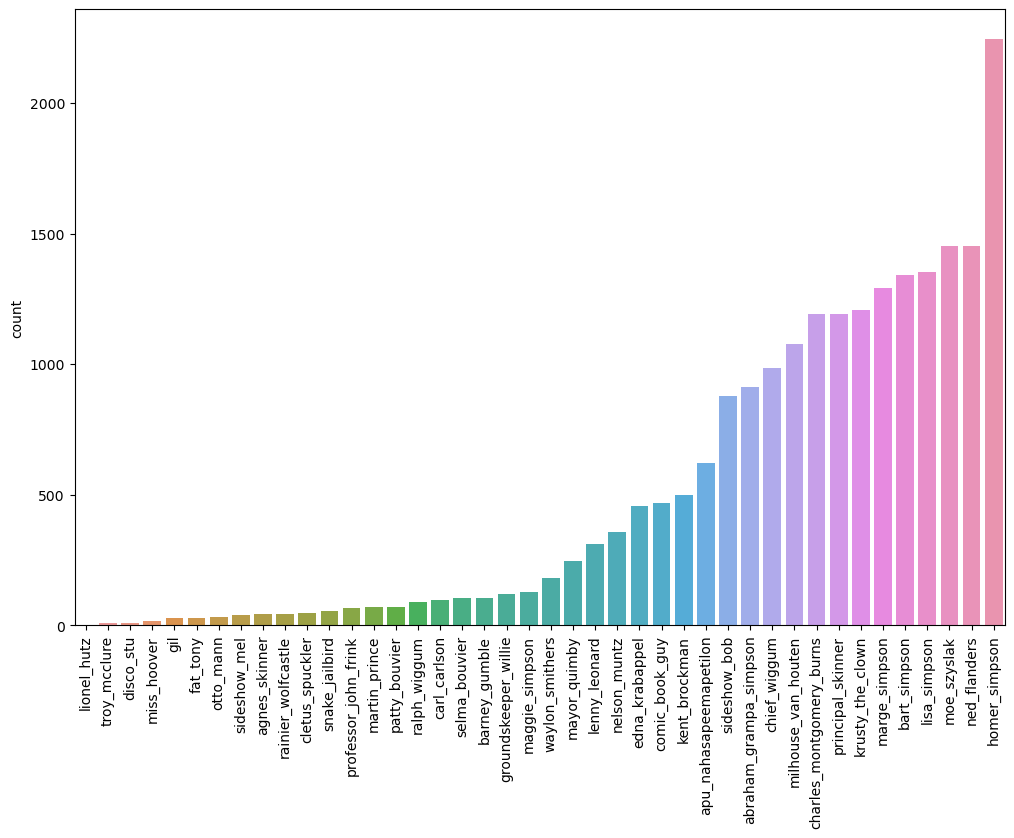

In [ ]:
import seaborn as sns
import pandas as pd
data = pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")
plt.figure(figsize=(12,8))
sns.barplot(x=data.index , y='count', data=data)
plt.xticks(rotation=90)
plt.show()

In [ ]:
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

def train(train_files, val_files, model, epochs, batch_size, optimizer=None, criterion=None, sheduler=None):

    if optimizer is None: 
        optimizer = torch.optim.Adam(model.parameters()) 
            
    if criterion is None: 
        criterion = nn.CrossEntropyLoss() 

    best_model_wts = model.state_dict()
    best_acc = 0 

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # балансировка класса
    # Train
    class_count = Counter(train_dataset.labels)
    class_weights = {proportion: 1/cnt for proportion, cnt in class_count.items()}
    sample_weights = []

    for (label) in train_dataset.labels:
        class_weight = class_weights[label]
        sample_weights.append(class_weight)

    N_train = max(class_count.values()) * len(class_count) 
    train_sampler = WeightedRandomSampler(sample_weights, num_samples=N_train, replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

    # Val
    class_count = Counter(val_dataset.labels)
    class_weights = {proportion: 1/cnt for proportion, cnt in class_count.items()}
    sample_weights = []
    for i, (label) in enumerate(val_dataset.labels):
        class_weight = class_weights[label]
        sample_weights.append(class_weight)

    N_val = max(class_count.values()) * len(class_count)
    val_sampler = WeightedRandomSampler(sample_weights, num_samples=N_val, replacement=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # opt = torch.optim.Adam(model.parameters())
        # criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            # train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, sheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc)) 
    model.load_state_dict(best_model_wts)

    return model, history
            
    # return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
# DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda")

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')
test_dataset = SimpsonsDataset(test_files, mode="test")

In [ ]:
# history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

In [ ]:
!pip install labml-nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 24.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 15.4 MB/s eta 0:00:00
  Created wheel for fairscale: filename=fairscale-0.4.6-py3-none-any.whl size=307224 sha256=cec273f82f97bd36cefef700b5cb01b1577fe90c7cd6f6223d8b1d46e588c0cd
  Stored in directory: /root/.cache/pip/wheels/0b/8c/fa/a9e102632bcb86e919561cf25ca1e0dd2ec67476f3a5544653
Successfully built fairscale


In [ ]:
from torch.optim import lr_scheduler
from labml_nn.optimizers import WeightDecay
from labml_nn.optimizers.adam import Adam

In [ ]:
model = simple_cnn
optimizer = Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99)) 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 

In [ ]:
model, history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=640, optimizer=optimizer, sheduler=exp_lr_scheduler)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.7411870699927435


epoch:   5%|▌         | 1/20 [09:26<2:59:31, 566.92s/it]


Epoch 001 train_loss: 0.7412     val_loss 2.0438 train_acc 0.8521 val_acc 0.5463
loss 0.08879380182153147


epoch:  10%|█         | 2/20 [18:29<2:45:47, 552.66s/it]


Epoch 002 train_loss: 0.0888     val_loss 2.1232 train_acc 0.9804 val_acc 0.5345
loss 0.039657105104663824


epoch:  15%|█▌        | 3/20 [27:28<2:34:46, 546.29s/it]


Epoch 003 train_loss: 0.0397     val_loss 2.0842 train_acc 0.9915 val_acc 0.5767
loss 0.02806801943449956


epoch:  20%|██        | 4/20 [36:28<2:25:01, 543.83s/it]


Epoch 004 train_loss: 0.0281     val_loss 2.5187 train_acc 0.9933 val_acc 0.5444
loss 0.026414019870900984


epoch:  25%|██▌       | 5/20 [45:29<2:15:45, 543.03s/it]


Epoch 005 train_loss: 0.0264     val_loss 2.2176 train_acc 0.9932 val_acc 0.5781
loss 0.006509749714189064


epoch:  30%|███       | 6/20 [54:33<2:06:42, 543.03s/it]


Epoch 006 train_loss: 0.0065     val_loss 2.2133 train_acc 0.9985 val_acc 0.6123
loss 0.0029531877442785454


epoch:  35%|███▌      | 7/20 [1:03:35<1:57:38, 542.99s/it]


Epoch 007 train_loss: 0.0030     val_loss 2.3285 train_acc 0.9995 val_acc 0.6069
loss 0.0009806191186541658


epoch:  40%|████      | 8/20 [1:12:39<1:48:37, 543.10s/it]


Epoch 008 train_loss: 0.0010     val_loss 2.4339 train_acc 0.9998 val_acc 0.5952
loss 0.005671228115029609


epoch:  45%|████▌     | 9/20 [1:21:40<1:39:28, 542.57s/it]


Epoch 009 train_loss: 0.0057     val_loss 2.7538 train_acc 0.9986 val_acc 0.5499
loss 0.005380842322304578


epoch:  50%|█████     | 10/20 [1:30:41<1:30:21, 542.15s/it]


Epoch 010 train_loss: 0.0054     val_loss 2.4832 train_acc 0.9985 val_acc 0.5948
loss 0.0015501131689927942


epoch:  55%|█████▌    | 11/20 [1:39:46<1:21:26, 542.93s/it]


Epoch 011 train_loss: 0.0016     val_loss 2.3750 train_acc 0.9997 val_acc 0.6189
loss 0.00035504599430453683


epoch:  60%|██████    | 12/20 [1:48:47<1:12:19, 542.46s/it]


Epoch 012 train_loss: 0.0004     val_loss 2.3762 train_acc 0.9999 val_acc 0.6334
loss 0.0002440751149613765


epoch:  65%|██████▌   | 13/20 [1:57:49<1:03:14, 542.11s/it]


Epoch 013 train_loss: 0.0002     val_loss 2.3138 train_acc 0.9999 val_acc 0.6299
loss 0.00013436430382677268


epoch:  70%|███████   | 14/20 [2:06:51<54:13, 542.18s/it]  


Epoch 014 train_loss: 0.0001     val_loss 2.3529 train_acc 1.0000 val_acc 0.6278
loss 0.00018208731971205568


epoch:  75%|███████▌  | 15/20 [2:15:51<45:07, 541.55s/it]


Epoch 015 train_loss: 0.0002     val_loss 2.3635 train_acc 1.0000 val_acc 0.6234
loss 0.00016161497346518046


epoch:  80%|████████  | 16/20 [2:24:56<36:09, 542.48s/it]


Epoch 016 train_loss: 0.0002     val_loss 2.3999 train_acc 1.0000 val_acc 0.6353
loss 0.00016022623085087682


epoch:  85%|████████▌ | 17/20 [2:33:57<27:06, 542.11s/it]


Epoch 017 train_loss: 0.0002     val_loss 2.4015 train_acc 1.0000 val_acc 0.6367
loss 0.00016562532442832438


epoch:  90%|█████████ | 18/20 [2:42:58<18:03, 541.87s/it]


Epoch 018 train_loss: 0.0002     val_loss 2.3615 train_acc 0.9999 val_acc 0.6407
loss 8.529603127583743e-05


epoch:  95%|█████████▌| 19/20 [2:52:01<09:02, 542.09s/it]


Epoch 019 train_loss: 0.0001     val_loss 2.4447 train_acc 1.0000 val_acc 0.6374
loss 0.00022030666108547318


epoch: 100%|██████████| 20/20 [3:01:02<00:00, 543.10s/it]


Epoch 020 train_loss: 0.0002     val_loss 2.4859 train_acc 0.9999 val_acc 0.6440
Best val Acc: 0.000000


In [ ]:
train_dataset = SimpsonsDataset(train_val_files, mode='train')
test_dataset = SimpsonsDataset(train_val_files, mode="test")

In [ ]:
model, history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=640, optimizer=optimizer, sheduler=exp_lr_scheduler)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.0910603848347145


epoch:   5%|▌         | 1/20 [11:14<3:33:44, 674.99s/it]


Epoch 001 train_loss: 0.0911     val_loss 0.0993 train_acc 0.9833 val_acc 0.9799
loss 0.016161400952154445


epoch:  10%|█         | 2/20 [22:52<3:26:32, 688.45s/it]


Epoch 002 train_loss: 0.0162     val_loss 0.0313 train_acc 0.9968 val_acc 0.9939
loss 0.005864536693613572


epoch:  15%|█▌        | 3/20 [34:09<3:13:34, 683.19s/it]


Epoch 003 train_loss: 0.0059     val_loss 0.0121 train_acc 0.9989 val_acc 0.9981
loss 0.0024504951235075224


epoch:  20%|██        | 4/20 [45:27<3:01:33, 680.87s/it]


Epoch 004 train_loss: 0.0025     val_loss 0.0038 train_acc 0.9996 val_acc 0.9996
loss 0.0009382005696335118


epoch:  25%|██▌       | 5/20 [56:47<2:50:12, 680.85s/it]


Epoch 005 train_loss: 0.0009     val_loss 0.0020 train_acc 0.9999 val_acc 1.0000
loss 0.0006243298070059445


epoch:  30%|███       | 6/20 [1:08:11<2:39:04, 681.75s/it]


Epoch 006 train_loss: 0.0006     val_loss 0.0011 train_acc 1.0000 val_acc 1.0000
loss 0.00035414373624479225


epoch:  35%|███▌      | 7/20 [1:19:26<2:27:13, 679.49s/it]


Epoch 007 train_loss: 0.0004     val_loss 0.0007 train_acc 1.0000 val_acc 1.0000
loss 0.00022909799299693201


epoch:  40%|████      | 8/20 [1:30:47<2:16:00, 680.02s/it]


Epoch 008 train_loss: 0.0002     val_loss 0.0005 train_acc 1.0000 val_acc 1.0000
loss 0.00019127525595852293


epoch:  45%|████▌     | 9/20 [1:42:08<2:04:42, 680.20s/it]


Epoch 009 train_loss: 0.0002     val_loss 0.0003 train_acc 1.0000 val_acc 1.0000
loss 0.00030350586461278087


epoch:  50%|█████     | 10/20 [1:53:27<1:53:21, 680.12s/it]


Epoch 010 train_loss: 0.0003     val_loss 0.0002 train_acc 0.9999 val_acc 1.0000
loss 9.88102572637867e-05


epoch:  55%|█████▌    | 11/20 [2:04:47<1:41:59, 679.99s/it]


Epoch 011 train_loss: 0.0001     val_loss 0.0002 train_acc 1.0000 val_acc 1.0000
loss 8.971457108490792e-05


epoch:  60%|██████    | 12/20 [2:16:03<1:30:30, 678.79s/it]


Epoch 012 train_loss: 0.0001     val_loss 0.0001 train_acc 1.0000 val_acc 1.0000
loss 0.00016135753916029363


epoch:  65%|██████▌   | 13/20 [2:27:12<1:18:50, 675.74s/it]


Epoch 013 train_loss: 0.0002     val_loss 0.0001 train_acc 0.9999 val_acc 1.0000
loss 8.407518262572946e-05


epoch:  70%|███████   | 14/20 [2:38:26<1:07:31, 675.18s/it]


Epoch 014 train_loss: 0.0001     val_loss 0.0001 train_acc 1.0000 val_acc 1.0000
loss 4.7249517363252026e-05


epoch:  75%|███████▌  | 15/20 [2:49:41<56:16, 675.28s/it]  


Epoch 015 train_loss: 0.0000     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000
loss 7.229656946574131e-05


epoch:  80%|████████  | 16/20 [3:00:57<45:01, 675.32s/it]


Epoch 016 train_loss: 0.0001     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000
loss 9.430548042631524e-05


epoch:  85%|████████▌ | 17/20 [3:12:11<33:45, 675.11s/it]


Epoch 017 train_loss: 0.0001     val_loss 0.0000 train_acc 0.9999 val_acc 1.0000
loss 9.603131552963867e-05


epoch:  90%|█████████ | 18/20 [3:23:23<22:28, 674.20s/it]


Epoch 018 train_loss: 0.0001     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000
loss 7.683126033768198e-05


epoch:  95%|█████████▌| 19/20 [3:34:33<11:12, 672.79s/it]


Epoch 019 train_loss: 0.0001     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000
loss 9.565623306370239e-05


epoch: 100%|██████████| 20/20 [3:45:45<00:00, 677.27s/it]


Epoch 020 train_loss: 0.0001     val_loss 0.0000 train_acc 0.9999 val_acc 1.0000
Best val Acc: 0.000000


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

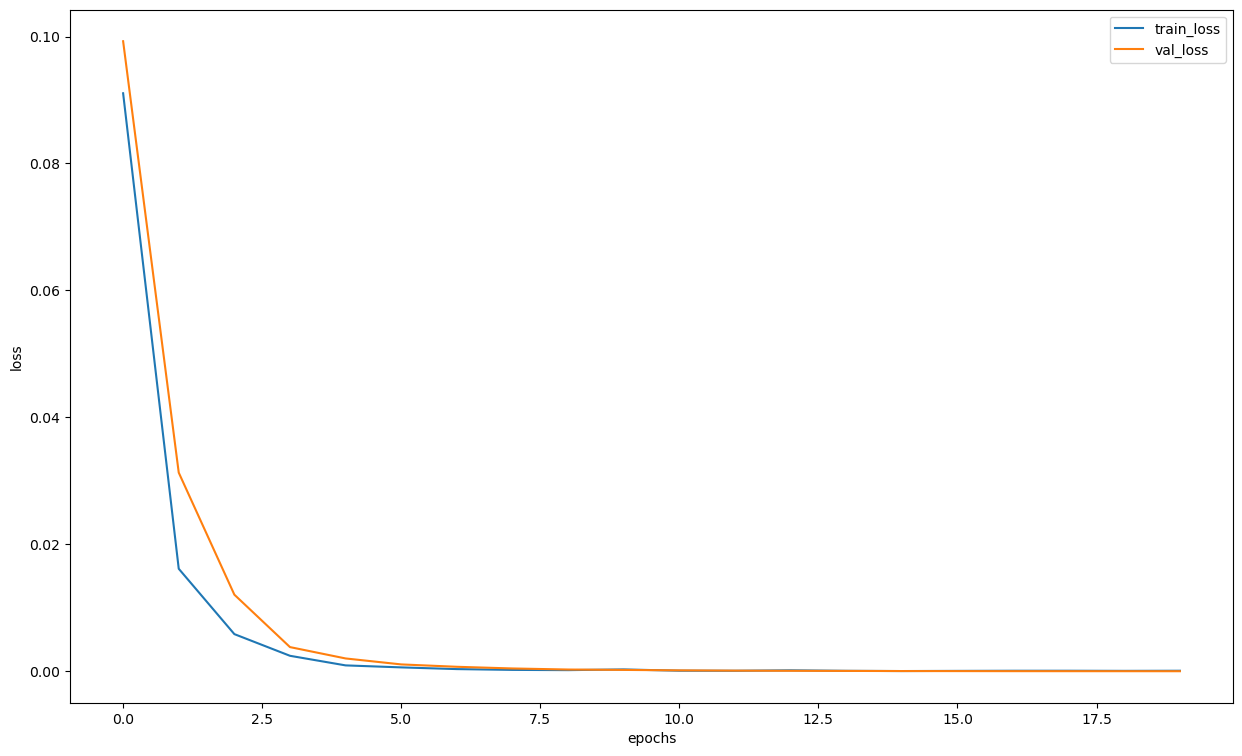

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

# f1_score(actual_labels, preds_class)
f1_score(actual_labels, y_pred, average='micro')

1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

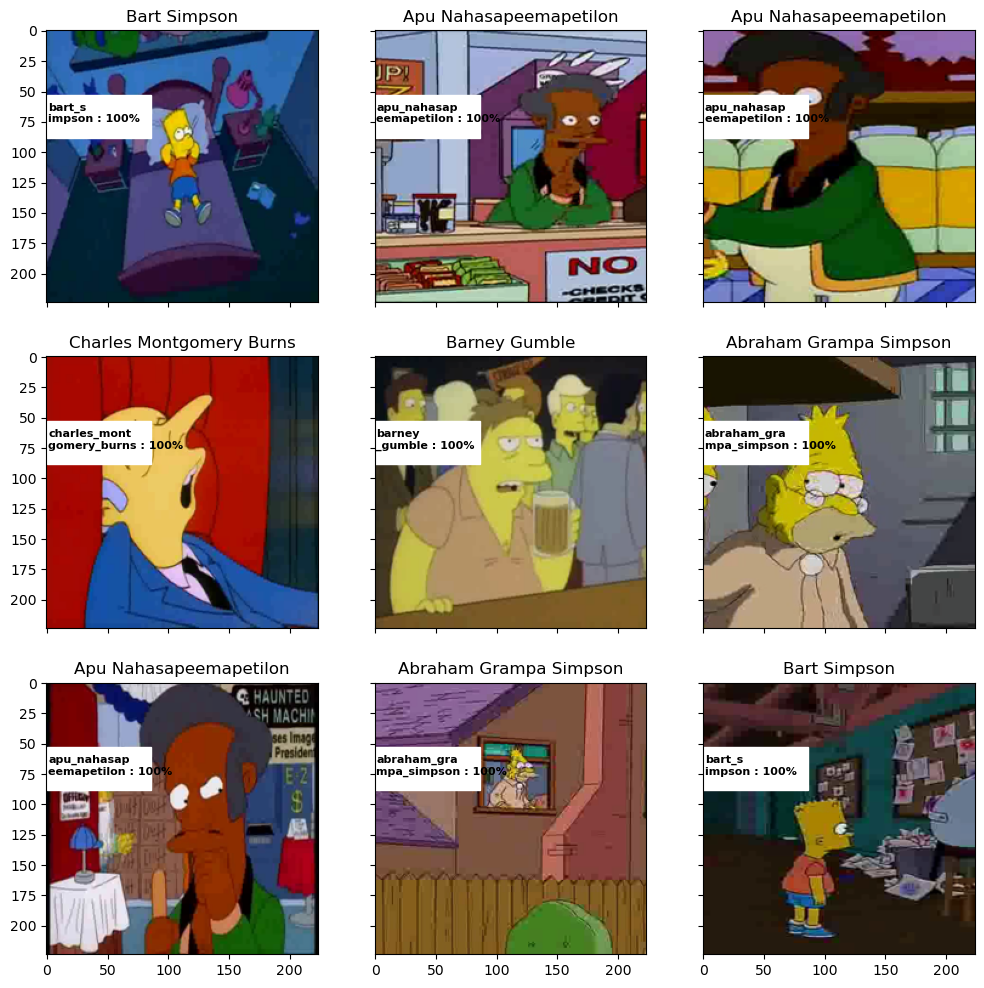

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

__notebook_source__.ipynb  label_encoder.pkl


In [ ]:
import pandas as pd
sub_path = '/kaggle/input/journey-springfield/sample_submission.csv'
my_submit = pd.read_csv(sub_path)
# my_submit = pd.read_csv("gdrive/MyDrive/simpsons/data/labels.csv")
# my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [ ]:
# my_submit.to_csv('gdrive/MyDrive/simpsons/simple_cnn_baseline.csv', index=False)
# my_submit.to_csv('gdrive/MyDrive/simpsons/new_baseline.csv', index=False)
my_submit.to_csv('/kaggle/working/simple_cnn_baseline-balance.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


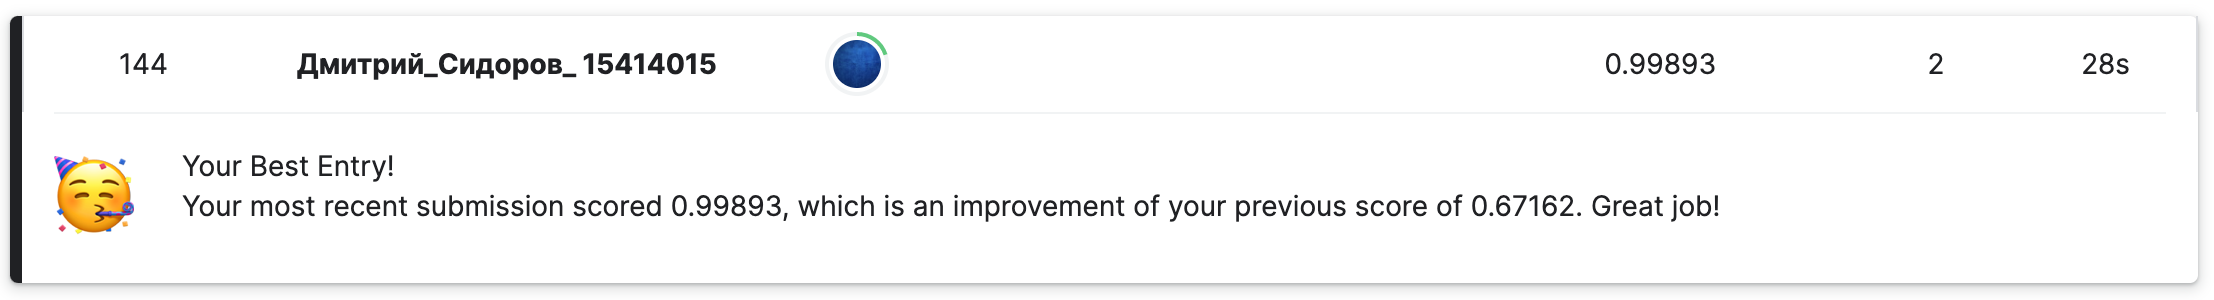

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
